In [1]:
from pathlib import Path
parent_dir = str(Path.cwd().parent)
%cd $parent_dir

/Users/tomtalpir/Random/pyERGM


In [17]:
from utils import *
from ergm import ERGM
from metrics import *

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


# Replicating the `Sampson` example from R's ERGM
The original R ERGM paper (Hunter et al. 2008) begins with a basic example of modeling Sampson's Monestary data, which consists of a directed network with $n=18$ nodes. This network models social interactions among a group of monks (See Sampson 1969 for more details). 

In the paper, An ERGM model is fit based on the Sampson network, using `num_of_edges` as its sole feature. The R fit yields a coefficient of `-0.9071582`, which is our aim.

optimization started
Step 0 - true_grad: 0, grad: [0.], window_grad: 75.25 lr: 0.0010000000, thetas: [0.18749424], time from start: 0.04, n_networks_for_grad_estimation: 200, sliding_grad_window_k: 10


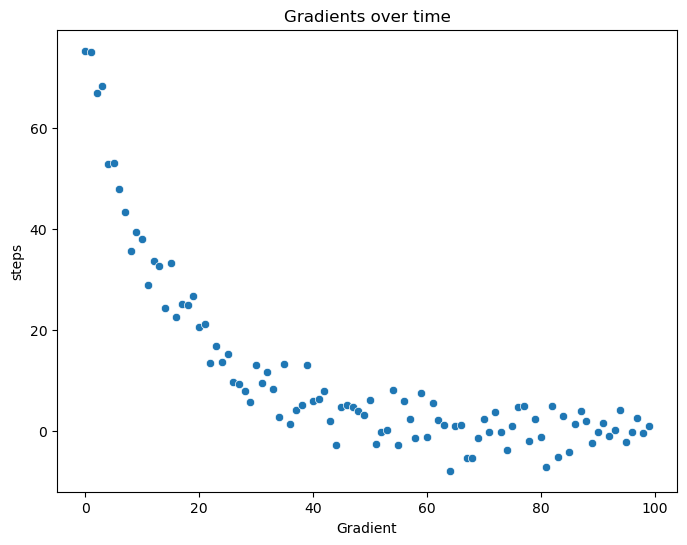

Fitted theta: [-0.87467933]


In [28]:
# Matrix copied manually, TODO - Create a `data` dir in our project and save as a pickle or something.
sampson_matrix = np.array(
    [[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1], 
    [0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0], 
    [1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0], 
    [0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], 
    [0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], 
    [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0], 
    [1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], 
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0], 
    [0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1], 
    [1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0]]
)

n = sampson_matrix.shape[0]
is_directed = True

metrics_calc = MetricsCollection([NumberOfEdges()], is_directed=is_directed)
fitted_model = ERGM(n, metrics_calc, is_directed=is_directed, n_networks_for_grad_estimation=200, n_mcmc_steps=50)

grads, _ = fitted_model.fit(sampson_matrix, lr=0.001, opt_steps=100, sliding_grad_window_k=10, sample_pct_growth=0.05)

grads = [x[0] for x in grads]


fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(grads, ax=ax)
ax.set(xlabel='Gradient', ylabel='steps')
ax.set_title("Gradients over time")

plt.show()

print(f"Fitted theta: {fitted_model._thetas}")

As we can see, our model reaches a theta that is extremely close to the actual R result.

### Initialize an ERGM with random coefficients

In [4]:
n_nodes = 10
stats_calculator = MetricsCollection([NumberOfEdges()], is_directed=False)


ergm = ERGM(n_nodes, stats_calculator, is_directed=False)

ergm.print_model_parameters()

Number of nodes: 10
Thetas: [-0.03087983]
Normalization factor approx: 62.45477141452264
Is directed: False


### Sample networks from the distribution, and calculate some statistics on the distribution

In [10]:
network_stats = []
for i in range(10):
    W = ergm.sample_network(sampling_method="NaiveMetropolisHastings", steps=1000)
    G = connectivity_matrix_to_G(W, directed=False)
    edge_count = len(G.edges())
    triangle_count = sum(nx.triangles(G).values()) // 3

    network_stats.append({"edge_count": edge_count, "triangle_count": triangle_count})

network_stats_df = pd.DataFrame(network_stats)
network_stats_df.head(20)


,edge_count,triangle_count
0,45,120
1,45,120
2,45,120
3,45,120
4,45,120
5,45,120
6,45,120
7,45,120
8,45,120
9,45,120


## Fit an ERGM

We begin by initializing an ERGM with predefined parameters - 

In [5]:
n_nodes = 5
stats_calculator = MetricsCollection([NumberOfEdges()], is_directed=False)

theta = -np.log(3)
ergm = ERGM(n_nodes, stats_calculator, is_directed=False, initial_thetas=[theta])

print("Baseline ERGM parameters - ")
ergm.print_model_parameters()


Baseline ERGM parameters - 
Number of nodes: 5
Thetas: [-1.0986122886681098]
Normalization factor approx: 44.59660413274814
Is directed: False


We now sample from this model a network that will become our "observed network", when estimating our fit performance.

In [9]:
W = ergm.sample_network(sampling_method="NaiveMetropolisHastings", steps=1000)

G = connectivity_matrix_to_G(W, directed=False)

real_edge_count = len(G.edges())
real_triangle_count = sum(nx.triangles(G).values()) // 3

print(f"Sampled a random network from a model with theta = {theta}")
print(W)
print(f"Network has statistics - edge count: {real_edge_count}, triangle count: {real_triangle_count}")

Sampled a random network from a model with theta = -1.0986122886681098
[[0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0.]]
Network has statistics - edge count: 3, triangle count: 0


Now, fit a random ERGM to create networks with similar statistics

In [10]:
fitted_ergm = ERGM(n_nodes, stats_calculator, is_directed=False)
print(f"Initial ERGM parameters:")
fitted_ergm.print_model_parameters()

pre_fit_W_matrices = []
samples_before_fit = []

n_samples = 10

for i in range(n_samples):
    sampled_W = fitted_ergm.sample_network(sampling_method="NaiveMetropolisHastings", steps=1000)
    G = connectivity_matrix_to_G(sampled_W, directed=False)
    edge_count = len(G.edges())
    triangle_count = sum(nx.triangles(G).values()) // 3

    samples_before_fit.append({"edge_count": edge_count, "triangle_count": triangle_count})
    pre_fit_W_matrices.append(sampled_W)

samples_before_fit_df = pd.DataFrame(samples_before_fit)
print("")
# Print mean for each metric - 
print(f"Mean of samples before fitting, calculated on {n_samples} samples- ")
print(samples_before_fit_df.mean())


Initial ERGM parameters:
Number of nodes: 5
Thetas: [0.18550661]
Normalization factor approx: 55.93379034441445
Is directed: False

Mean of samples before fitting, calculated on 10 samples- 
edge_count        5.0
triangle_count    1.0
dtype: float64


We now fit the ERGM!

In [13]:

print(f"Fitting ERGM...")
fitted_ergm.fit(W)
print("Done fitting!")


Fitting ERGM...
optimization started


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [48]:
print(f"Post fit ERGM parameters:")
fitted_ergm.print_model_parameters()

post_fit_W_matrices = []
samples_after_fit = []

for i in range(n_samples):
    sampled_W = fitted_ergm.sample_network(sampling_method="NaiveMetropolisHastings", steps=1000)
    G = connectivity_matrix_to_G(sampled_W, directed=False)
    edge_count = len(G.edges())
    triangle_count = sum(nx.triangles(G).values()) // 3

    samples_after_fit.append({"edge_count": edge_count, "triangle_count": triangle_count})
    post_fit_W_matrices.append(sampled_W)

samples_after_fit_df = pd.DataFrame(samples_after_fit)
print("")

print(f"Mean of samples after fitting, calculated on {n_samples} samples- ")
print(samples_after_fit_df.mean())



Post fit ERGM parameters:
Number of nodes: 5
Thetas: [-0.15381744]
Normalization factor approx: 135.44816303424523
Is directed: False

Mean of samples after fitting, calculated on 10 samples- 
edge_count        8.4
triangle_count    6.0
dtype: float64


$$
\hat{\theta} = -0.1538 , \theta = -0.3369
\\
$$

edge count and triangle_count not looking better than the random ergm...